In [1]:
import pickle
with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import time

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
lat_rho = np.transpose(lat_rho, axes=(1, 0))
f  = dataset.variables['f'][:]
f = np.transpose(f, axes=(1, 0))
h = dataset.variables['h'][:]
h = np.transpose(h, axes=(1, 0))
z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
temp_ave = np.load('/srv/scratch/z5297792/Climatology/temp_ave.npy')
CurSpeed_ave = np.load('/srv/scratch/z5297792/Climatology/CurSpeed_ave.npy')


In [3]:
import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

def eddy_centric_grid_distances(i_search, j_search, i_left, i_right, j_down, j_up):
    lonc = lon_rho[i_search, j_search]
    latc = lat_rho[i_search, j_search]
    def make_left_values_negative(arr):
        zero_index = np.where(arr == 0)[0]
        if zero_index.size == 0:
            return arr
        zero_index = zero_index[0]
        arr[:zero_index] = -np.abs(arr[:zero_index])
        return arr
    x = make_left_values_negative(distance(latc, lonc, lat_rho[i_left:i_right,j_search], lon_rho[i_left:i_right,j_search]))
    y = make_left_values_negative(distance(latc, lonc, lat_rho[i_search,j_down:j_up], lon_rho[i_search,j_down:j_up]))
    return x.data, y.data

def eddies_nearest_rho(elon, elat):
    dataset = nc.Dataset('/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc')
    lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
    lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
    R = np.sqrt((lon_rho - elon)**2 + (lat_rho - elat)**2)
    i_search, j_search = np.unravel_index(np.argmin(R), R.shape)
    return i_search, j_search

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357000
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)
    dlat, dlon = lat2_rad - lat1_rad, lon2_rad - lon1_rad
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

def grid_finder(i_search, j_search, SEARCH_WIDTH):
    fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
    dataset = nc.Dataset(fname)
    lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
    lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
    
    def within_search_width(i_offset, j_offset):
        return distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search],
                        lat_rho[i_search + i_offset, j_search + j_offset], 
                        lon_rho[i_search + i_offset, j_search + j_offset]) < SEARCH_WIDTH / 2

    i_left, i_right = 0, 0
    j_down, j_up = 0, 0

    while i_search - i_left >= 0 and within_search_width(-i_left, 0):
        i_left += 1
    while i_search + i_right < lon_rho.shape[0] and within_search_width(i_right, 0):
        i_right += 1
    while j_search - j_down >= 0 and within_search_width(0, -j_down):
        j_down += 1
    while j_search + j_up < lon_rho.shape[1] and within_search_width(0, j_up):
        j_up += 1

    i_left = max(i_search - i_left + 1, 0)
    i_right = min(i_search + i_right, lon_rho.shape[0])
    j_down = max(j_search - j_down + 1, 0)
    j_up = min(j_search + j_up, lon_rho.shape[1])

    return i_left, i_right, j_down, j_up

def tilt_distance(x, y):
    if np.all(np.isnan(x)):
        return np.nan
    else:
        return np.sqrt( (np.nanmax(x)-np.nanmin(x))**2 + (np.nanmax(y)-np.nanmin(y))**2 )

def rotate_20_clockwise(x, y):
    theta = np.deg2rad(20)
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    points = np.vstack((x, y))
    rotated_points = rotation_matrix @ points
    x_rotated, y_rotated = rotated_points
    return x_rotated, y_rotated

def make_cartesian(lon, lat, theta0, phi0):
    lonr, latr = np.deg2rad(lon), np.deg2rad(lat)
    r_earth = 6371
    x = r_earth * np.cos(np.deg2rad(phi0)) * (lonr - np.deg2rad(theta0))
    y = r_earth * (latr - np.deg2rad(phi0))
    return x, y


In [4]:
def extract_velocity(eddy_name, eddies):
    edata = eddies[eddy_name]
    
    # Extract middle 30 days
    middle_index = edata.shape[0] // 2
    t0 = extract_number(edata.iloc[middle_index - 15].name) 
    tN = extract_number(edata.iloc[middle_index + 15].name) 
    
    # Initialize arrays
    U1 = np.zeros((lon_rho.shape[0], lon_rho.shape[1], z_r.shape[-1], tN - t0))
    V1 = np.zeros_like(U1)
    
    # Calculate time moduli and file indices
    t_mod0, t_modN = t0 % 30, tN % 30
    file_idx0, file_idxN = int(t0 // 30), int(tN // 30)
    t_pres = 30 - t_mod0
    
    for file_idx in range(file_idx0, file_idxN + 1):
        fnumber = str(f"{1461 + file_idx * 30:05d}")
        
        # Calculate start and end indices
        start_idx = t_mod0 if file_idx == file_idx0 else 0
        end_idx = t_modN if file_idx == file_idxN else 30
        
        # Load data from the file
        U_chunk = np.load(f'/srv/scratch/z5297792/Climatology/u_v/u_{fnumber}.npy')[:, :, :, start_idx:end_idx]
        V_chunk = np.load(f'/srv/scratch/z5297792/Climatology/u_v/v_{fnumber}.npy')[:, :, :, start_idx:end_idx]
        
        # Fill data into arrays
        if file_idx == file_idx0:
            U1[:, :, :, :t_pres] = U_chunk
            V1[:, :, :, :t_pres] = V_chunk
        elif file_idx == file_idxN:
            U1[:, :, :, t_pres:] = U_chunk
            V1[:, :, :, t_pres:] = V_chunk
        else:
            U1[:, :, :, t_pres:(t_pres + 30)] = U_chunk
            V1[:, :, :, t_pres:(t_pres + 30)] = V_chunk
            t_pres += 30
    
    # Set invalid data to NaN
    U1 = np.where(np.abs(U1) > 1e30, np.nan, U1)
    V1 = np.where(np.abs(V1) > 1e30, np.nan, V1)
    
    return U1, V1

def interpolate_to_dx_spacing(x, y, Z, dx):
    # Define x and y ranges based on dx
    x_min, x_max = np.round(np.array([np.min(x), np.max(x)]) / dx) * dx
    y_min, y_max = np.round(np.array([np.min(y), np.max(y)]) / dx) * dx

    xy_abs = min(abs(x_min), abs(x_max), abs(y_min), abs(y_max))
    x_new = np.arange(-xy_abs, xy_abs + dx, dx)
    y_new = np.arange(-xy_abs, xy_abs + dx, dx)
    
    # Create the new interpolated Z array with shape (len(y_new), len(x_new), depth_levels)
    depth_levels = Z.shape[2]
    Z_new = np.zeros((len(y_new), len(x_new), depth_levels))
    
    # Interpolate at each depth level
    for k in range(depth_levels):
        original_points = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)
        values = Z[:, :, k].flatten()
        new_points = np.array(np.meshgrid(x_new, y_new)).T.reshape(-1, 2)
        
        Z_new[:, :, k] = griddata(original_points, values, new_points, method='linear').reshape(len(y_new), len(x_new))
    
    return x_new, y_new, Z_new

def chunk_interpolator(t, U1, V1, DEPTH_LVL_LIMIT):

    t0 = eddies[sample_eddy].shape[0] // 2 - 15
    t_eddy_relative = t + t0
    edata = eddies[sample_eddy].iloc[t_eddy_relative]
    i_search, j_search = eddies_nearest_rho(edata.Lon, edata.Lat)
    
    i_left, i_right, j_down, j_up = grid_finder(i_search, j_search, SEARCH_WIDTH)
    x_roms, y_roms = eddy_centric_grid_distances(i_search, j_search, i_left, i_right, j_down, j_up)

    _, _, U = interpolate_to_dx_spacing(x_roms, y_roms, U1[i_left:i_right, j_down:j_up,:DEPTH_LVL_LIMIT,t], dx)
    x, y, V = interpolate_to_dx_spacing(x_roms, y_roms, V1[i_left:i_right, j_down:j_up,:DEPTH_LVL_LIMIT,t], dx)

    return {'U': U, 'V': V, 'x': x, 'y': y, 'z': z_r[150, 150, :DEPTH_LVL_LIMIT]}



In [5]:
SEARCH_WIDTH = 300000
DEPTH_LVL_LIMIT = 23
dx = 3000

sample_eddies = daydic['Day100'].loc[daydic['Day100']['Age'] > 30].index

# sample_data = {}
# for sample_eddy in sample_eddies:
#     tic = time.time()
#     U1, V1 = extract_velocity(sample_eddy, eddies)
    
#     sample_data[sample_eddy] = {f'T{t}': chunk_interpolator(t, U1, V1, DEPTH_LVL_LIMIT) for t in range(U1.shape[-1])}
#     toc = time.time()
#     print(f"Elapsed time: {toc - tic:.4f} seconds")
#     print(sample_eddy)

# with open('/srv/scratch/z5297792/Sample/sample_data.pkl', 'wb') as file:
#     pickle.dump(sample_data, file)

with open('/srv/scratch/z5297792/Sample/sample_data.pkl', 'rb') as file:
    sample_data = pickle.load(file)
sample_data.keys()

dict_keys(['Eddy8', 'Eddy9', 'Eddy22', 'Eddy32', 'Eddy60', 'Eddy110', 'Eddy117', 'Eddy124', 'Eddy133', 'Eddy134', 'Eddy141', 'Eddy142', 'Eddy149', 'Eddy151', 'Eddy161', 'Eddy171'])

## COW

In [6]:
def calculate_okubo_weis(uu, vv, dx, dy):

    WIDTH, LENGTH, SIGMAS = uu.shape
    u_x = (uu[2:,:,:] - uu[:-2,:,:]) / (2*dx)
    u_y = (uu[:,2:,:] - uu[:,:-2,:]) / (2*dy)
    v_x = (vv[2:,:,:] - vv[:-2,:,:]) / (2*dx)
    v_y = (vv[:,2:,:] - vv[:,:-2,:]) / (2*dy)
    u_x = np.concatenate((np.zeros((1, LENGTH, SIGMAS)), u_x, np.zeros((1, LENGTH, SIGMAS))), axis=0)
    v_x = np.concatenate((np.zeros((1, LENGTH, SIGMAS)), v_x, np.zeros((1, LENGTH, SIGMAS))), axis=0)
    u_y = np.concatenate((np.zeros((WIDTH, 1, SIGMAS)), u_y, np.zeros((WIDTH, 1, SIGMAS))), axis=1)
    v_y = np.concatenate((np.zeros((WIDTH, 1, SIGMAS)), v_y, np.zeros((WIDTH, 1, SIGMAS))), axis=1)
    s_n = u_x - v_y
    s_s = v_x + u_y
    vort = v_x - u_y
    ow = s_n**2 + s_s**2 - vort**2
    return ow
    
def normalize_matrix(LOW):
    ocean_mask = np.where(np.isnan(LOW), np.zeros_like(LOW), 1)
    OW_mean = np.nansum(LOW) / np.sum(ocean_mask)
    OW_std = np.sqrt(np.nansum(ocean_mask * (LOW - OW_mean) ** 2) / np.sum(ocean_mask))
    return LOW / OW_std

In [19]:
for sample_eddy in sample_eddies:
    start_time = time.time()
    for t in range(30):
    
        U = sample_data[sample_eddy]['T'+str(t)]['U']
        V = sample_data[sample_eddy]['T'+str(t)]['V']
        x = sample_data[sample_eddy]['T'+str(t)]['x']
        y = sample_data[sample_eddy]['T'+str(t)]['y']
        
        dx = x[1] - x[0]
        ow = normalize_matrix(calculate_okubo_weis(U, V, dx, dx))
        cs = np.sqrt(U**2 + V**2)

        X, Y = np.meshgrid(x, y)
        
        CS_THRESH = 0.05
        OW_THRESH = -.2
        RATIO_THRESH = 2/3
        SEARCH_RADIUS_MAX = 50000
        
        xc, yc = 0, 0
        depth_dics3 = {}
        for depth_lvl in range(DEPTH_LVL_LIMIT):
            Search_Radius = 5000
            df = pd.DataFrame({'x': [np.nan, np.nan], 'y': [np.nan, np.nan]})
            xc_keep, yc_keep = np.nan, np.nan
            
            if depth_lvl == 0 or not np.isnan(depth_dics3['Depth' + str(depth_lvl - 1)]['xc']):
                while Search_Radius <= SEARCH_RADIUS_MAX:
                    R = np.sqrt((X - xc)**2 + (Y - yc)**2)
                    mask = R < Search_Radius
                    cur_speed_masked = np.where(mask, cs[:, :, depth_lvl], np.nan) 
                    ow_masked = np.where(mask, ow[:, :, depth_lvl], np.nan) 
                    pot_i, pot_j = np.where((cur_speed_masked < CS_THRESH) & (ow_masked < OW_THRESH))
                    ratio = len(pot_i) / np.sum(mask) if len(pot_i) != 0 else 0
                    if ratio <= RATIO_THRESH and ratio != 0:
                        A = np.array([x[pot_i], y[pot_j]])
                        xc, yc = np.mean(A, axis=1)
                        xc_keep, yc_keep = xc, yc
                        df = pd.DataFrame({
                            'x': x[pot_i],
                            'y': y[pot_j],
                            'OW': ow_masked[pot_i, pot_j],
                            'CurSpeed': cur_speed_masked[pot_i, pot_j]
                        })
                        break
                    Search_Radius += 5000

            depth_dics3['Depth'+str(depth_lvl)] = {'xc': xc_keep, 'yc': yc_keep, 'SR': Search_Radius,
                                           'x': x, 'y': y, 'dx': dx, 'df': df,
                                          'Depth': z_r[150, 150, depth_lvl]}
    
        xcs, ycs, zcs = [], [], []
        for depth_dic in depth_dics3.values():
            xcs.append(depth_dic['xc']/1000)
            ycs.append(depth_dic['yc']/1000)
            zcs.append(depth_dic['Depth'])
        
        sample_data[sample_eddy]['T'+str(t)]['COW'] = pd.DataFrame({
            'x': xcs,
            'y': ycs,
            'Depth': zcs,
            'TD': [tilt_distance(xcs, ycs)] * len(xcs)
        })
    end_time = time.time()
    print(sample_eddy)
    print(f"Elapsed time: {end_time - start_time} seconds")
        

Eddy8
Elapsed time: 0.6616382598876953 seconds
Eddy9
Elapsed time: 0.6219227313995361 seconds
Eddy22
Elapsed time: 0.6169447898864746 seconds
Eddy32
Elapsed time: 0.3151109218597412 seconds
Eddy60
Elapsed time: 0.3157958984375 seconds
Eddy110
Elapsed time: 0.6288037300109863 seconds
Eddy117
Elapsed time: 0.3306312561035156 seconds
Eddy124
Elapsed time: 0.31571292877197266 seconds
Eddy133
Elapsed time: 0.6873414516448975 seconds
Eddy134
Elapsed time: 0.6435635089874268 seconds
Eddy141
Elapsed time: 0.5413196086883545 seconds
Eddy142
Elapsed time: 0.6484723091125488 seconds
Eddy149
Elapsed time: 0.5541632175445557 seconds
Eddy151
Elapsed time: 0.5577950477600098 seconds
Eddy161
Elapsed time: 0.45853209495544434 seconds
Eddy171
Elapsed time: 0.6191375255584717 seconds


Text(0.5, 0.98, 'TD = 4 km')

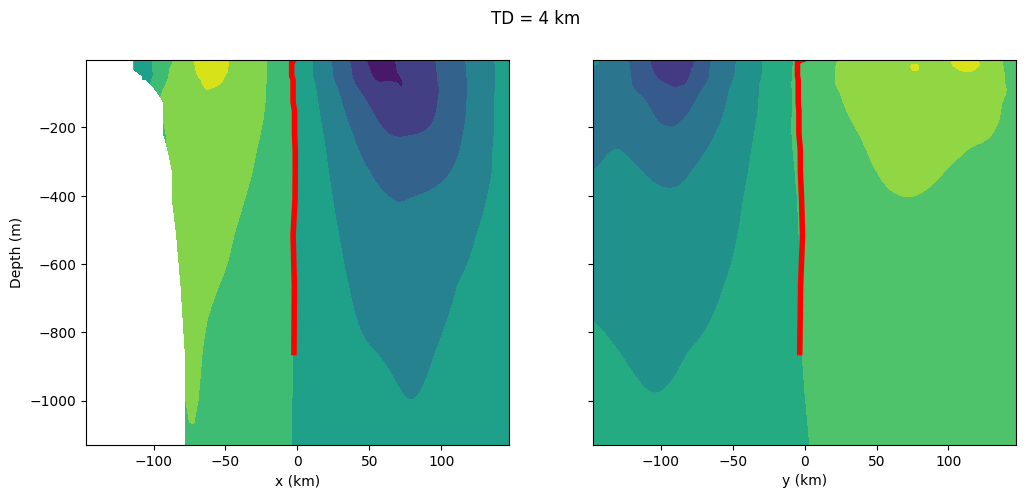

In [8]:
sample_eddy = 'Eddy134'

t = 10

U = sample_data[sample_eddy]['T'+str(t)]['U']
V = sample_data[sample_eddy]['T'+str(t)]['V']
x = sample_data[sample_eddy]['T'+str(t)]['x']/1000
y = sample_data[sample_eddy]['T'+str(t)]['y']/1000
z = sample_data[sample_eddy]['T'+str(t)]['z']
COW_data = sample_data[sample_eddy]['T'+str(t)]['COW']

xc, yc, zc = COW_data.x, COW_data.y, COW_data.Depth

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
X, Z = np.meshgrid(x, z)
axs[0].contourf(X, Z, V[:, V.shape[1]//2, :].T)
axs[0].plot(xc, zc, linewidth=4, color='r')
axs[0].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (m)')
Y, Z = np.meshgrid(y, z)
axs[1].contourf(Y, Z, U[U.shape[0]//2, :, :].T)
axs[1].plot(yc, zc, linewidth=4, color='r')
axs[1].set_xlabel('y (km)')
# axs[1].set_ylabel('Depth (m)')
TD = f"{round(COW_data['TD'][0])} km" if 'TD' in COW_data and not np.isnan(COW_data['TD'][0]) else 'NaN'
plt.suptitle(f'TD = {TD}')

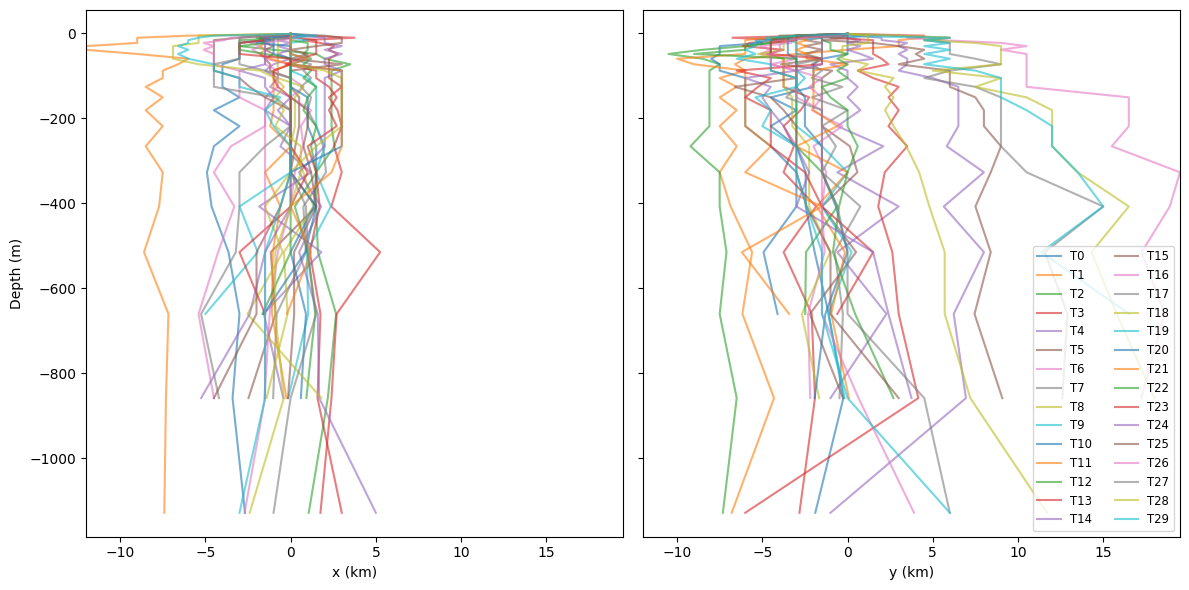

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

x_min, x_max = float('inf'), float('-inf')

for t in range(30):
    data = sample_data[sample_eddy]['T' + str(t)]['COW']
    x_vals, y_vals = data['x'] - data['x'][0], data['y'] - data['y'][0]
    ax1.plot(x_vals, data['Depth'], alpha=0.6)
    ax2.plot(y_vals, data['Depth'], alpha=0.6, label='T' + str(t))
    x_min, x_max = min(x_min, x_vals.min(), y_vals.min()), max(x_max, x_vals.max(), y_vals.max())

ax1.set_xlim(x_min, x_max)
ax2.set_xlim(x_min, x_max)
ax1.set_xlabel("x (km)"); ax1.set_ylabel("Depth (m)")
ax2.set_xlabel("y (km)")
ax2.legend(loc='best', fontsize='small', ncol=2)
plt.tight_layout()
plt.show()


## Analysis to find Sample

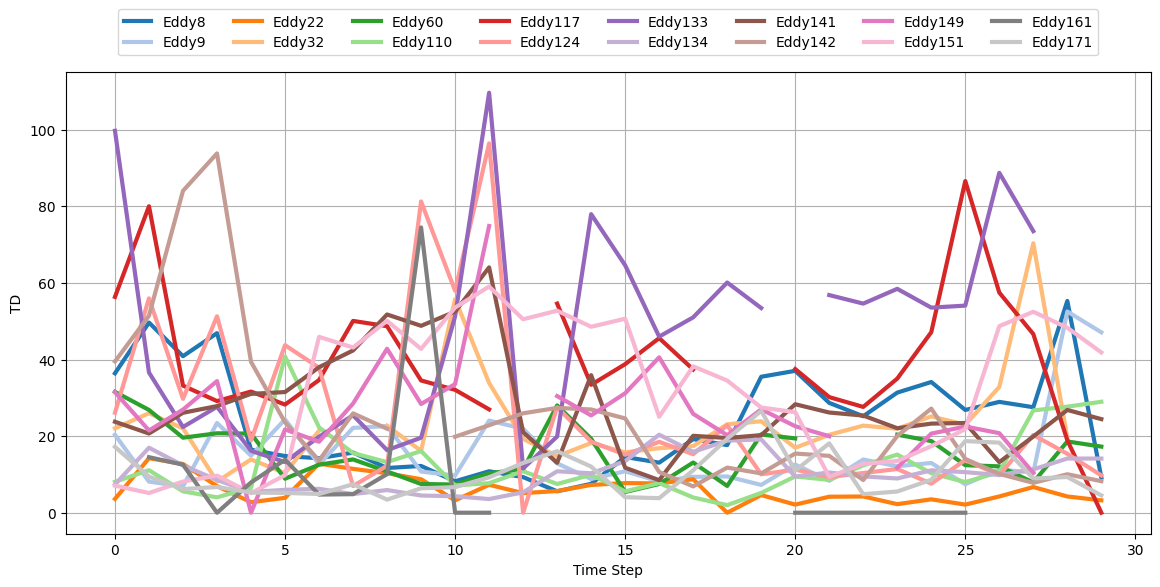

,TD
Eddy22,6.053002
Eddy161,8.278874
Eddy171,10.059872
Eddy134,10.321163
Eddy110,12.288791
Eddy60,15.342411
Eddy9,15.915897
Eddy32,23.371786
Eddy8,23.486093
Eddy142,24.716061


In [10]:

plt.figure(figsize=(14, 6))

# Get the tab20 colormap
cmap = plt.colormaps['tab20']
TD_mean = []
for i, sample_eddy in enumerate(sample_eddies):
    TD = []
    for t in range(30):
        TD.append(sample_data[sample_eddy]['T'+str(t)]['COW']['TD'][0])
    plt.plot(np.arange(30), TD, label=sample_eddy, linewidth=3, color=cmap(i))
    TD_mean.append(np.nanmean(TD))
df = pd.DataFrame({'TD': TD_mean})
df.index = sample_eddies

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(sample_eddies) // 2)
plt.xlabel('Time Step')
plt.ylabel('TD')
plt.grid()
plt.show()

df = df.sort_values(by="TD", ascending=True)
df

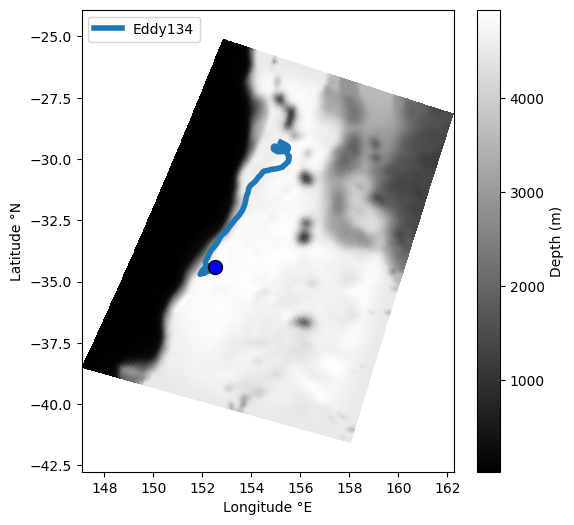

In [11]:
colors = plt.get_cmap('tab20')
plt.figure(figsize=(6, 6))
plt.pcolormesh(lon_rho, lat_rho, h, shading='auto', cmap='gray')
plt.colorbar(label='Depth (m)')
plt.xlabel('Longitude °E')
plt.ylabel('Latitude °N')
for i, e in enumerate(['Eddy134']):
    eddy_data = eddies[e]
    plt.plot(eddy_data['Lon'], eddy_data['Lat'], color=colors(i), label=e, linewidth=4)
    plt.scatter(eddy_data['Lon'].iloc[-1], eddy_data['Lat'].iloc[-1], color='r' if eddy_data['Vort'].iloc[-1] > 0 else 'b', edgecolor='black', s=100, zorder=5)
plt.axis('equal')
plt.legend(loc='upper left')
plt.show()

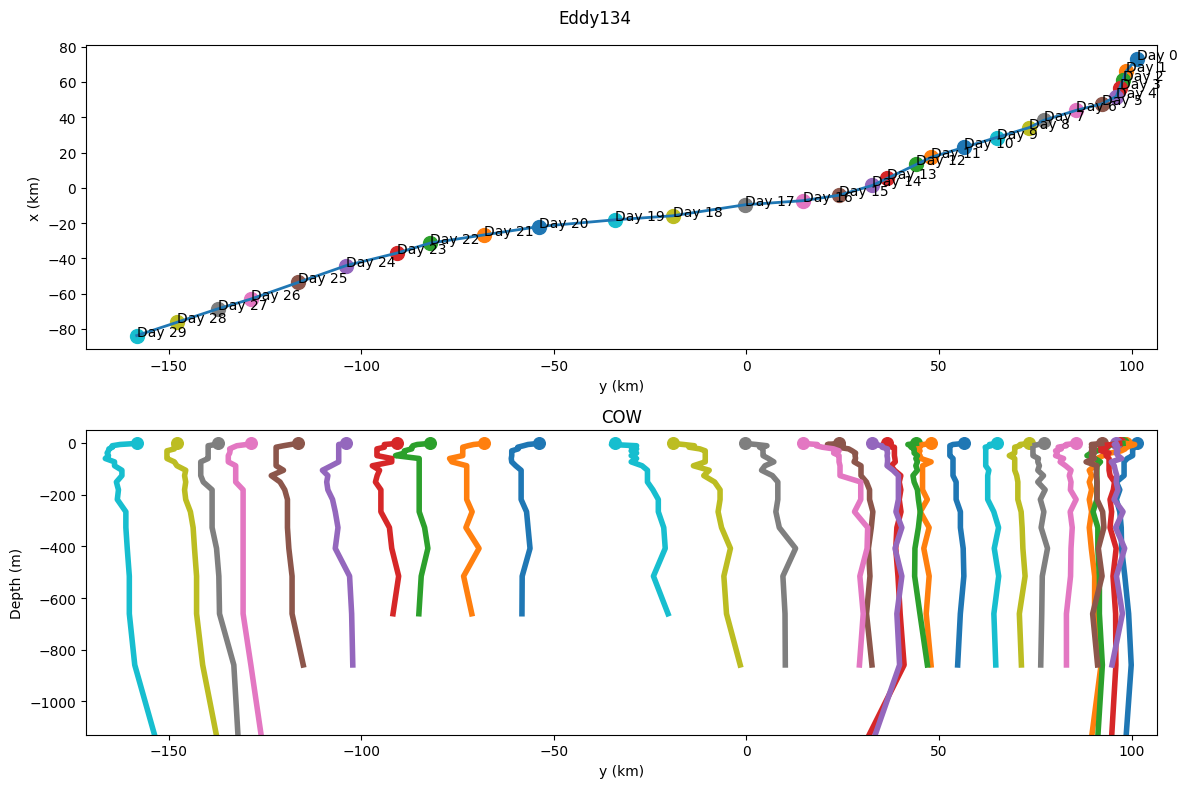

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8))

# eddy = 'Eddy133' # AE tilt
eddy = 'Eddy134' # CE non-tilt
# eddy = 'Eddy22' # AE no-tilt
# eddy = 'Eddy149' # AE tilt
# eddy = 'Eddy134'

edata = eddies[eddy].iloc[eddies[eddy].shape[0] // 2 - 15:eddies[eddy].shape[0] // 2 + 15]
x, y = make_cartesian(edata.Lon, edata.Lat, edata.Lon.mean(), edata.Lat.mean())
eddy_path = pd.DataFrame({'x': x, 'y': y})

# Plot the eddy path
axs[0].plot(eddy_path['y'], eddy_path['x'], linewidth=2)
axs[0].set_xlabel('y (km)')
axs[0].set_ylabel('x (km)')

y_min = float('inf')
y_max = float('-inf')
for t in range(30):
    time_data = sample_data[eddy]['T' + str(t)]['COW']
    x, y = rotate_20_clockwise(time_data['x'], time_data['y'])
    y = y - y[0] + eddy_path.iloc[t].y

    y_min = min(y_min, np.nanmin(y), np.nanmin(eddy_path['y']))
    y_max = max(y_max, np.nanmax(y), np.nanmax(eddy_path['y']))
y_min -= 5
y_max += 5

for t in range(30):
    axs[0].scatter(eddy_path.iloc[t]['y'], eddy_path.iloc[t]['x'], s=100)
    axs[0].text(eddy_path.iloc[t]['y'], eddy_path.iloc[t]['x'], 'Day ' + str(t))

    time_data = sample_data[eddy]['T' + str(t)]['COW']
    x, y = rotate_20_clockwise(time_data['x'], time_data['y'])

    y = y - y[0] + eddy_path.iloc[t].y
    z = time_data['Depth']
    # INCLUDE THIS IN Y_MIN Y_MAX
    axs[1].plot(y, z, linewidth=4)
    axs[1].scatter(y[0], z[0], s=70)
    axs[1].set_ylim([50, z_r[150, 150, DEPTH_LVL_LIMIT-1]])
    axs[1].invert_yaxis()
    axs[1].set_title('COW')
    axs[1].set_xlabel('y (km)')
    axs[1].set_ylabel('Depth (m)')

axs[0].set_xlim(y_min, y_max)
axs[1].set_xlim(y_min, y_max)

plt.suptitle(eddy)
plt.tight_layout()
plt.show()


In [13]:
# eddy = 'Eddy133' # CE tilt
# eddy = 'Eddy134' # CE non-tilt
# eddy = 'Eddy22' # AE non-tilt
# eddy = 'Eddy149' # AE tilt

# the_chosen_eddies = ['Eddy22', 'Eddy149', 'Eddy134', 'Eddy133']

the_chosen_eddies = ['Eddy134']

Now apply the other methods to the `chosen' sample

## VG

In [14]:
def nenc_crit_1_2(u, v, a):
    rows_v, cols_v = v.shape
    rows_u, cols_u = u.shape
    if rows_v != rows_u or cols_v != cols_u:
        raise ValueError("The shapes of 'v' and 'u' must be the same.")

    criteria_mask_1 = np.zeros_like(v, dtype=bool)
    criteria_mask_2 = np.zeros_like(u, dtype=bool)

    # First function nenc_crit_1
    for j in range(a, cols_v - a):
        wrk = v[:, j]
        s = np.sign(wrk)
        indx = np.where(np.diff(s) != 0)[0]
        for ii in indx:
            if ii - a >= 0 and ii + a < rows_v:  # Check boundaries
                if v[ii - a, j] * v[ii + a, j] < 0:
                    if abs(v[ii - a, j]) > abs(v[ii, j]) and abs(v[ii + a, j]) > abs(v[ii, j]):
                        criteria_mask_1[ii, j] = True

    # Second function nenc_crit_2, only checking where criteria_mask_1 is True
    for i in range(a, rows_u - a):
        wrk = u[i, :]
        s = np.sign(wrk)
        indx = np.where(np.diff(s) != 0)[0]
        for jj in indx:
            if criteria_mask_1[i, jj]:  # Only check where nenc_crit_1 is True
                if jj - a >= 0 and jj + a < cols_u:  # Check boundaries
                    if u[i, jj - a] * u[i, jj + a] < 0:
                        if abs(u[i, jj - a]) > abs(u[i, jj]) and abs(u[i, jj + a]) > abs(u[i, jj]):
                            criteria_mask_2[i, jj] = True

    return criteria_mask_2

def nenc_crit_3(u, v, b):
    velocity_magnitude = np.sqrt(u**2 + v**2)
    rows, cols = velocity_magnitude.shape
    local_minimum_mask = np.zeros_like(velocity_magnitude, dtype=bool)
    for i in range(b, rows - b):  
        for j in range(b, cols - b):  
            current_magnitude = velocity_magnitude[i, j]
            neighborhood = velocity_magnitude[i-b:i+b+1, j-b:j+b+1]
            if current_magnitude <= np.min(neighborhood):
                local_minimum_mask[i, j] = True
                # Set the 8 neighboring points to True, with boundary checks
                for di in [-1, 0, 1]:
                    for dj in [-1, 0, 1]:
                        ni, nj = i + di, j + dj
                        if 0 <= ni < rows and 0 <= nj < cols:  # Ensure neighbors are within bounds
                            local_minimum_mask[ni, nj] = True    
    return local_minimum_mask

def nenc_crit_4(u, v, a):

    # Assuming u and v are your 2D matrices of velocities
    rows, cols = u.shape

    # Create a mask to store points that meet the rotational consistency criterion
    rotation_mask = np.zeros_like(u, dtype=bool)

    def is_cyclic_rotation(lst):
        # Define allowed transitions for both patterns
        valid_pairs_1 = {(1, 2), (2, 3), (3, 4), (4, 1),  # Pattern 1: Ascending sequence
                         (1, 1), (2, 2), (3, 3), (4, 4)}  
        valid_pairs_2 = {(2, 1), (3, 2), (4, 3), (1, 4),  # Pattern 2: Descending sequence
                         (1, 1), (2, 2), (3, 3), (4, 4)}  
        
        # Helper function to check if the list satisfies a given set of valid pairs
        def check_valid(lst, valid_pairs):
            for i in range(1, len(lst)):
                if (lst[i-1], lst[i]) not in valid_pairs:
                    return False
            return True
    
        # Check both conditions
        check_1 = check_valid(lst, valid_pairs_1)
        check_2 = check_valid(lst, valid_pairs_2)
    
        # Return True if exactly one condition is satisfied
        return (check_1 or check_2) and not (check_1 and check_2)
    
    # Function to determine the quadrant of an angle
    def quadrant_check(u_bound, v_bound):
        u_bound, v_bound = np.array(u_bound), np.array(v_bound)
        quadrants = np.zeros(u_bound.shape, dtype=int)
        quadrants[(u_bound >= 0) & (v_bound >= 0)] = 1
        quadrants[(u_bound < 0) & (v_bound >= 0)] = 2
        quadrants[(u_bound < 0) & (v_bound < 0)] = 3
        quadrants[(u_bound >= 0) & (v_bound < 0)] = 4

        if np.any(quadrants==1) and np.any(quadrants==2) and np.any(quadrants==3) and np.any(quadrants==4):
            if is_cyclic_rotation(quadrants):
                return True
        
        return False

    # Function to check if two quadrants are adjacent
    def adjacent_quadrants(q1, q2):
        return abs(q1 - q2) == 1 or abs(q1 - q2) == 3  # Wrap-around (1 and 4 are adjacent)
        
    # Loop through each point (avoid the edges by 'a' grid points)
    for i in range(a, rows - a):
        for j in range(a, cols - a):
  
            u_bound = []
            u_bound.extend(u[i-a:i+a+1,j+a])
            u_bound.extend(np.flip(u[i+a,j-a:j+a+1]))
            u_bound.extend(np.flip(u[i-a:i+a+1,j-a]))
            u_bound.extend(u[i-a,j-a:j+a+1])

            v_bound = []
            v_bound.extend(v[i-a:i+a+1,j+a])
            v_bound.extend(np.flip(v[i+a,j-a:j+a+1]))
            v_bound.extend(np.flip(v[i-a:i+a+1,j-a]))
            v_bound.extend(v[i-a,j-a:j+a+1])
            
            if quadrant_check(u_bound, v_bound):
                rotation_mask[i, j] = True

    return rotation_mask

def polynomial_fit_with_error(x, y, degree=1):
    mask = ~np.isnan(x) & ~np.isnan(y)
    x, y = x[mask], y[mask]
    if degree not in [0, 1]:
        raise ValueError("Degree must be 0 or 1.")
    coefficients, cov = np.polyfit(x, y, degree, cov=True)  # coefficients = [slope, intercept]
    y_fit = np.polyval(coefficients, x)
    residuals = y - y_fit
    std_err_coeffs = np.sqrt(np.diag(cov))
    ss_total = np.sum((y - np.mean(y))**2)
    ss_residuals = np.sum(residuals**2)
    r_squared = 1 - (ss_residuals / ss_total)
    return coefficients, std_err_coeffs, r_squared

def haversine_distance(lat1, lon1, bearing, distance):
    R = 6371000
    lat1, lon1, bearing = map(math.radians, [lat1, lon1, bearing])

    lat2 = math.asin(math.sin(lat1) * math.cos(distance / R) +
                     math.cos(lat1) * math.sin(distance / R) * math.cos(bearing))
    lon2 = lon1 + math.atan2(math.sin(bearing) * math.sin(distance / R) * math.cos(lat1),
                             math.cos(distance / R) - math.sin(lat1) * math.sin(lat2))

    return math.degrees(lat2), math.degrees(lon2)

def true_bearing(x, y):
    angle_radians = math.atan2(y, x)
    angle_degrees = math.degrees(angle_radians)
    bearing = (90 - angle_degrees) % 360
    return bearing

def is_pos_def(Q):
    eigenvalues = np.linalg.eigvals(Q)
    return np.all(eigenvalues > 0)

def find_increasing_magnitude_sublist(lst, ic, tolerance=0):

    min_radial_dist = 3
    
    # Initialize sublist and index list with the center element
    sublist = [lst[ic]]
    indices = [ic]
    
    # Move left and check if magnitude increases with tolerance, at least 3 indices
    count_left = 0
    for i in range(ic - 1, -1, -1):
        if count_left < min_radial_dist:
            sublist.insert(0, lst[i])
            indices.insert(0, i)
            count_left += 1
        elif abs(lst[i]) >= abs(sublist[0]) - tolerance:
            sublist.insert(0, lst[i])
            indices.insert(0, i)
        else:
            break
    
    # Move right and check if magnitude increases with tolerance, at least 3 indices
    count_right = 0
    for i in range(ic + 1, len(lst)):
        if count_right < min_radial_dist:
            sublist.append(lst[i])
            indices.append(i)
            count_right += 1
        elif abs(lst[i]) >= abs(sublist[-1]) - tolerance:
            sublist.append(lst[i])
            indices.append(i)
        else:
            break
    
    return np.array(sublist), indices


In [18]:
for eddy in the_chosen_eddies:
    start_time = time.time()
    for t in range(30):
    
        U = sample_data[eddy]['T'+str(t)]['U']
        V = sample_data[eddy]['T'+str(t)]['V']
        x = sample_data[eddy]['T'+str(t)]['x']
        y = sample_data[eddy]['T'+str(t)]['y']
        dx = x[1] - x[0]
    
        # Nencioli
                
        a, b = 4, 3
        R_BETWEEN_ADJACENT_CENTERS = 30000
        depth_dics1 = {}
        
        for depth_lvl in range(U.shape[-1]):
            u, v = U[:, :, depth_lvl], V[:, :, depth_lvl]
            
            combined = np.logical_and.reduce((nenc_crit_1_2(u, v, a), nenc_crit_3(u, v, b), nenc_crit_4(u, v, a)))
            ic, jc = np.where(combined)
        
            ic_pre, jc_pre = (u.shape[0] // 2, u.shape[1] // 2) if depth_lvl == 0 else (depth_dics1[f'Depth{depth_lvl-1}']['n_ic'], depth_dics1[f'Depth{depth_lvl-1}']['n_jc'])
            
            R = np.sqrt((ic - ic_pre) ** 2 + (jc - jc_pre) ** 2) * dx
            ic, jc = ic[R < R_BETWEEN_ADJACENT_CENTERS], jc[R < R_BETWEEN_ADJACENT_CENTERS]
            
            if len(ic) > 1:
                min_idx = np.argmin(np.sqrt(u[ic, jc]**2 + v[ic, jc]**2))
                ic, jc = [int(ic[min_idx])], [int(jc[min_idx])]
            elif len(ic) == 0:
                ic, jc = np.nan, np.nan
        
            depth_dics1[f'Depth{depth_lvl}'] = {
                'n_ic': ic[0] if not np.isnan(ic).any() else np.nan,
                'n_jc': jc[0] if not np.isnan(jc).any() else np.nan,
                'n_xc': x[ic] if not np.isnan(ic).any() else np.nan,
                'n_yc': y[jc] if not np.isnan(jc).any() else np.nan
            }

        # MOCA
            
        from scipy.signal import argrelextrema
        for depth_lvl in range(U.shape[-1]):

            depth_dic = depth_dics1['Depth'+str(depth_lvl)]
            
            n_xc, n_yc, n_ic, n_jc = depth_dic['n_xc'], depth_dic['n_yc'], depth_dic['n_ic'], depth_dic['n_jc']
    
            u = U[:, :, depth_lvl]
            v = V[:, :, depth_lvl]
    
            if not np.isnan(n_ic):
                                                                                                                  
                u1 = u[:, n_jc].squeeze()
                v1 = v[:, n_jc].squeeze()
            
                u2 = u[n_ic, :].squeeze()
                v2 = v[n_ic, :].squeeze()
            
                u2, u_ind = find_increasing_magnitude_sublist(u2, n_jc)
                v2 = v2[u_ind]
            
                yy = (np.array(u_ind) - n_jc) * dx
            
                v1, v_ind = find_increasing_magnitude_sublist(v1, n_ic)
                u1 = u1[v_ind]
                xx = (np.array(v_ind) - n_ic) * dx
                
                As, dAs, r2A = polynomial_fit_with_error(xx, u1, degree=1)
                A1, A0 = As
                Bs, dBs, r2B = polynomial_fit_with_error(xx, v1, degree=1)
                B1, B0 = Bs
                Cs, dCs, r2C = polynomial_fit_with_error(yy, u2, degree=1)
                C1, C0 = Cs
                Ds, DAs, r2D = polynomial_fit_with_error(yy, v2, degree=1)
                D1, D0 = Ds
                alpha = A0 if r2A < r2B else C0
                beta = B0 if r2B < r2D else D0
                gamma = A1 if r2A < r2D else -D1
                q11, q12, q22 = B1 / 2, -gamma / 2, -C1 / 2
                Q = np.array([[q11, q12], [q12, q22]])
                if is_pos_def(Q) or is_pos_def(-Q):
                    yc = (q11 * alpha + q12 * beta) / (2 * (q11 * q22 - q12 ** 2))  
                    xc = (alpha * q12 + beta * q22) / (2 * (q12 ** 2 - q11 * q22))      
            
                    xc += n_xc
                    yc += n_yc
            
                else:
                    xc = yc = np.nan
    
                dfx = pd.DataFrame({'x': xx + n_xc, 'y': [n_yc] * len(xx), 'u1': u1, 'v1': v1})
                dfy = pd.DataFrame({'y': yy + n_yc, 'x': [n_xc] * len(yy), 'u2': u2, 'v2': v2})
    
            else:
                
                dfx, dfy, q11, q12, q22, xc, yc = np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    
            depth_dics1[f'Depth{depth_lvl}']['dfx'] = dfx
            depth_dics1[f'Depth{depth_lvl}']['dfy'] = dfy
            depth_dics1[f'Depth{depth_lvl}']['q11'] = q11
            depth_dics1[f'Depth{depth_lvl}']['q12'] = q12
            depth_dics1[f'Depth{depth_lvl}']['q22'] = q22
            depth_dics1[f'Depth{depth_lvl}']['xc'] = np.nan if np.isnan(xc) else xc[0]
            depth_dics1[f'Depth{depth_lvl}']['yc'] = np.nan if np.isnan(yc) else yc[0]
            depth_dics1[f'Depth{depth_lvl}']['Depth'] = z_r[150, 150, depth_lvl]
        
        xcs, ycs, zcs, n_xcs, n_ycs = [], [],[], [], []
        for depth_dic in depth_dics1.values():
            xcs.append(depth_dic['xc']/1000)
            ycs.append(depth_dic['yc']/1000)
            n_xcs.append(depth_dic['n_xc']/1000)
            n_ycs.append(depth_dic['n_yc']/1000)
            zcs.append(depth_dic['Depth'])
        
        sample_data[eddy]['T'+str(t)]['VG'] = pd.DataFrame({
            'x': xcs,
            'y': ycs,
            'Depth': zcs,
            'TD': [tilt_distance(xcs, ycs)] * len(xcs)
        })
        print(t)
    end_time = time.time()
    print(f"Elapsed time: {end_time - start_time} seconds")
    print(eddy)

Elapsed time: 248.41496562957764 seconds


Text(0.5, 0.98, 'TD = 20 km')

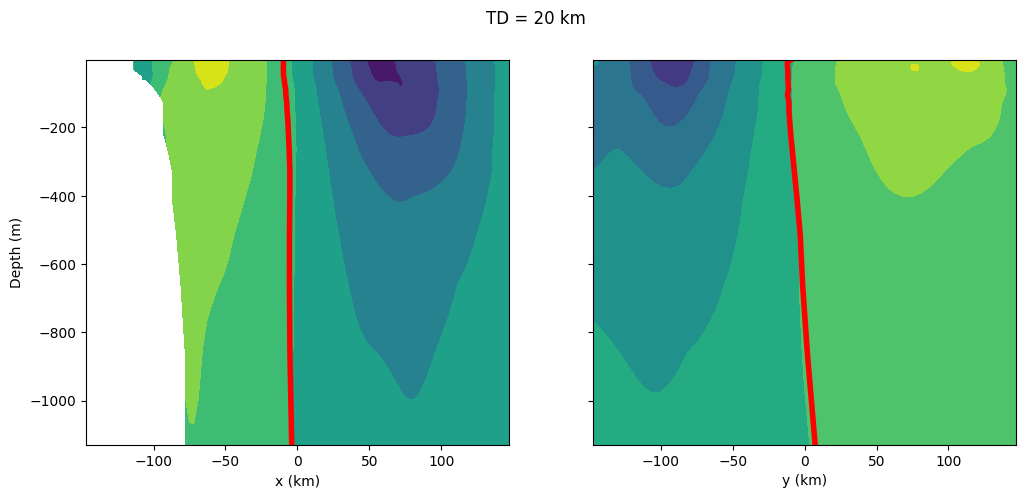

In [21]:
eddy = the_chosen_eddies[0]

t = 10

U = sample_data[eddy]['T'+str(t)]['U']
V = sample_data[eddy]['T'+str(t)]['V']
x = sample_data[eddy]['T'+str(t)]['x']/1000
y = sample_data[eddy]['T'+str(t)]['y']/1000
z = sample_data[eddy]['T'+str(t)]['z']
VG_data = sample_data[eddy]['T'+str(t)]['VG']

xc, yc, zc = VG_data.x, VG_data.y, VG_data.Depth

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
X, Z = np.meshgrid(x, z)
axs[0].contourf(X, Z, V[:, V.shape[1]//2, :].T)
axs[0].plot(xc, zc, linewidth=4, color='r')
axs[0].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (m)')
Y, Z = np.meshgrid(y, z)
axs[1].contourf(Y, Z, U[U.shape[0]//2, :, :].T)
axs[1].plot(yc, zc, linewidth=4, color='r')
axs[1].set_xlabel('y (km)')
# axs[1].set_ylabel('Depth (m)')
TD = f"{round(VG_data['TD'][0])} km" if 'TD' in VG_data and not np.isnan(VG_data['TD'][0]) else 'NaN'
plt.suptitle(f'TD = {TD}')

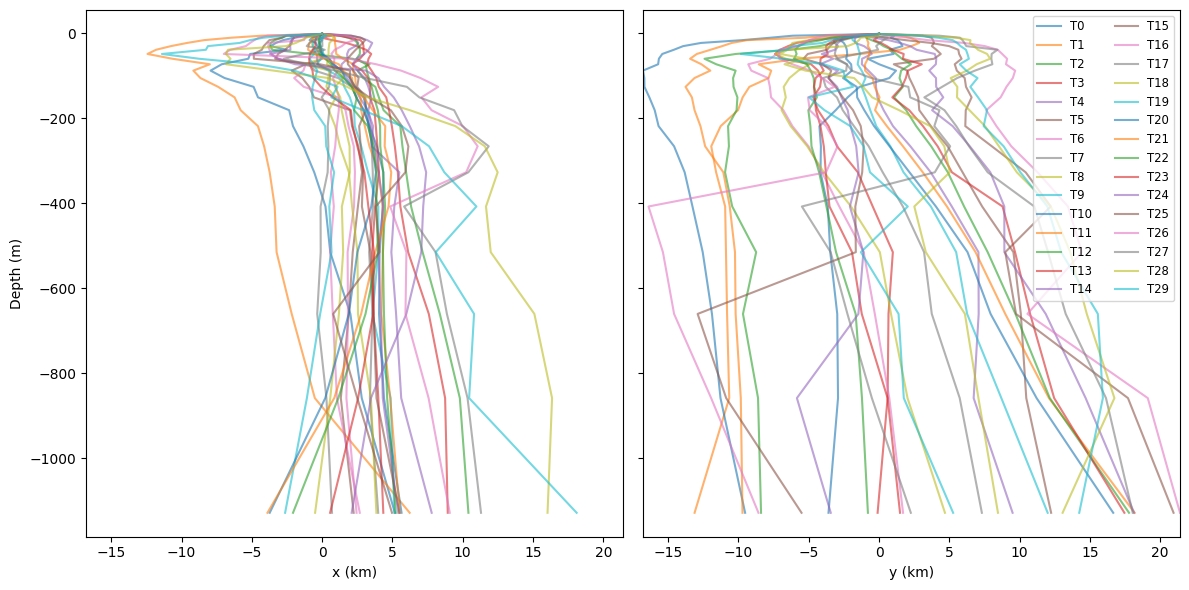

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

x_min, x_max = float('inf'), float('-inf')

for t in range(30):
    data = sample_data[eddy]['T' + str(t)]['VG']
    x_vals, y_vals = data['x'] - data['x'][0], data['y'] - data['y'][0]
    ax1.plot(x_vals, data['Depth'], alpha=0.6)
    ax2.plot(y_vals, data['Depth'], alpha=0.6, label='T' + str(t))
    x_min, x_max = min(x_min, x_vals.min(), y_vals.min()), max(x_max, x_vals.max(), y_vals.max())

ax1.set_xlim(x_min, x_max)
ax2.set_xlim(x_min, x_max)
ax1.set_xlabel("x (km)"); ax1.set_ylabel("Depth (m)")
ax2.set_xlabel("y (km)")
ax2.legend(loc='best', fontsize='small', ncol=2)
plt.tight_layout()
plt.show()

## LNAM

In [23]:
def calc_lnam(x, y, uu, vv):
    f = -1  # SH
    # Initialize arrays for spatial differences
    dx, dy = np.zeros_like(x), np.zeros_like(x)
    dux, duy, dvx, dvy = np.zeros_like(x), np.zeros_like(x), np.zeros_like(x), np.zeros_like(x)
    
    # Finite spatial element directly in meters
    dx[1:-1, 1:-1] = x[1:-1, 2:] - x[1:-1, :-2]
    dy[1:-1, 1:-1] = y[2:, 1:-1] - y[:-2, 1:-1]
    
    # Speed element in m/s
    dux[1:-1, 1:-1] = uu[1:-1, 2:] - uu[1:-1, :-2]
    duy[1:-1, 1:-1] = uu[2:, 1:-1] - uu[:-2, 1:-1]
    dvx[1:-1, 1:-1] = vv[1:-1, 2:] - vv[1:-1, :-2]
    dvy[1:-1, 1:-1] = vv[2:, 1:-1] - vv[:-2, 1:-1]

    epsilon = 1e-10  # A small number to prevent division by zero
    sn = np.divide((dux / (dx + epsilon)) - (dvy / (dy + epsilon)), 1, where=(dx > epsilon) & (dy > epsilon))
    ss = np.divide((dvx / (dx + epsilon)) + (duy / (dy + epsilon)), 1, where=(dx > epsilon) & (dy > epsilon))
    om = np.divide((dvx / (dx + epsilon)) - (duy / (dy + epsilon)), 1, where=(dx > epsilon) & (dy > epsilon))
    div = np.divide((dux / (dx + epsilon)) + (dvy / (dy + epsilon)), 1, where=(dx > epsilon) & (dy > epsilon))
    
    vorticity = om * np.sign(f)
    okubo = sn**2 + ss**2 - om**2  # in s^-2
    
    # Initialization
    LNAM, LOW = np.full_like(uu, np.nan), np.full_like(uu, np.nan)
    b = np.ones_like(x, dtype=int) # 2b is the side length of the local box
    borders = np.max(b) + 1
    
    # Loop through domain to calculate LNAM and LOW
    for i in range(borders, len(vv[:, 0]) - borders + 1):
        for j in range(borders, len(vv[0, :]) - borders + 1):
            if not np.isnan(vv[i, j]):
                OW = okubo[i - b[i, j]:i + b[i, j] + 1, j - b[i, j]:j + b[i, j] + 1]
                LOW[i, j] = np.nanmean(OW)
                
                xlocal = x[i - b[i, j]:i + b[i, j] + 1, j - b[i, j]:j + b[i, j] + 1]
                ylocal = y[i - b[i, j]:i + b[i, j] + 1, j - b[i, j]:j + b[i, j] + 1]
                ulocal = uu[i - b[i, j]:i + b[i, j] + 1, j - b[i, j]:j + b[i, j] + 1]
                vlocal = vv[i - b[i, j]:i + b[i, j] + 1, j - b[i, j] + 1]
                
                coordcentre = (xlocal.shape[0] - 1) // 2
                d_xcentre = (xlocal - xlocal[coordcentre, coordcentre])
                d_ycentre = (ylocal - ylocal[coordcentre, coordcentre])
                
                cross = (d_xcentre * vlocal) - (d_ycentre * ulocal)
                dot = (ulocal * d_xcentre) + (vlocal * d_ycentre)
                produit = np.sqrt(ulocal**2 + vlocal**2) * np.sqrt(d_xcentre**2 + d_ycentre**2)
                sumdp = np.sum(dot) + np.sum(produit)
                
                LNAM[i, j] = np.sum(cross) / sumdp * np.sign(f) if sumdp != 0 else 0
    
    # LNAM[np.isnan(LNAM)] = 0
    return LNAM, LOW

In [74]:
from scipy.ndimage import maximum_filter, minimum_filter

for eddy in the_chosen_eddies:
    start_time = time.time()
    for t in range(30):

        R_BETWEEN_ADJACENT_CENTERS = 15000
        
        U = sample_data[eddy]['T'+str(t)]['U']
        V = sample_data[eddy]['T'+str(t)]['V']
        x = sample_data[eddy]['T'+str(t)]['x']
        y = sample_data[eddy]['T'+str(t)]['y']
        dx = x[1] - x[0]
        
        depth_dics2 = {}
        for depth_lvl in range(U.shape[-1]):
            ic, jc = [], []
            u, v = U[:, :, depth_lvl], V[:, :, depth_lvl]
            X, Y = np.meshgrid(x, y)
            lnam, low = calc_lnam(X, Y, u, v)
            if np.any(np.isfinite(lnam)):
                window_size = 5
                if eddies[eddy].iloc[0].Vort < 0:
                    local_maxima = maximum_filter(lnam, size=window_size, mode='reflect')
                    local_maxima_positions = (lnam == local_maxima)
                    ic, jc = np.argwhere(local_maxima_positions).T
    
                elif eddies[eddy].iloc[0].Vort > 0:
                    local_minima = minimum_filter(lnam, size=window_size, mode='reflect')
                    local_minima_positions = (lnam == local_minima)
                    ic, jc = np.argwhere(local_minima_positions).T
                
                if depth_lvl == 0:
                    ic_pre, jc_pre = u.shape[0] // 2, u.shape[1] // 2
                else:
                    ic_pre, jc_pre = depth_dics2['Depth'+str(depth_lvl-1)]['ic'], depth_dics2['Depth'+str(depth_lvl-1)]['jc']
            
                R = np.sqrt((ic - ic_pre)**2 + (jc - jc_pre)**2) * dx

                if depth_lvl == 0:
                    ic = ic[R == np.nanmin(R)]
                    jc = jc[R == np.nanmin(R)]
                else:
                    ic = ic[R < R_BETWEEN_ADJACENT_CENTERS]
                    jc = jc[R < R_BETWEEN_ADJACENT_CENTERS]

                if len(ic) > 1:
                    vel_mag = np.sqrt(u[ic,jc]**2 + v[ic,jc]**2)
                    if edata.iloc[0]['Vort'] < 0:
                        idx = np.argmax(vel_mag)
                    elif edata.iloc[0]['Vort'] > 0:
                        idx = np.argmin(vel_mag)
                    ic, jc = [ic[idx]], [jc[idx]]
    
                if len(ic) > 0:
                    ic, jc = ic[0], jc[0]
                    xc = x[ic]
                    yc = y[jc]
                else:
                    ic, jc, xc, yc = np.nan, np.nan, np.nan, np.nan
            else:
                ic, jc, xc, yc = np.nan, np.nan, np.nan, np.nan

            depth_dics2['Depth'+str(depth_lvl)] = {'lnam': lnam, 'ic': ic, 'jc': jc,
                                                       'xc': xc, 'yc': yc,
                                                       'X': X, 'Y': Y, 'u': u, 'v': v,
                                                       'Depth': float(z_r[150, 150, depth_lvl])}
        xcs, ycs, zcs = [], [], []
        for depth_dic in depth_dics2.values():
            xcs.append(depth_dic['xc']/1000)
            ycs.append(depth_dic['yc']/1000)
            zcs.append(depth_dic['Depth'])

        sample_data[eddy]['T'+str(t)]['LNAM'] = pd.DataFrame({
            'x': xcs, 'y': ycs, 'Depth': zcs, 
            'TD': [tilt_distance(xcs, ycs)] * len(xcs)
        })
        print(t)
    end_time = time.time()
    print(eddy)
    print(f"Elapsed time: {end_time - start_time} seconds")


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


/scratch/pbs.5932640.kman.restech.unsw.edu.au/ipykernel_1410647/2680878443.py:36: RuntimeWarning: Mean of empty slice
  LOW[i, j] = np.nanmean(OW)


18
19
20
21
22
23
24
25
26
27
28
29
Eddy134
Elapsed time: 241.54347777366638 seconds


nan
nan


/scratch/pbs.5932640.kman.restech.unsw.edu.au/ipykernel_1410647/581647435.py:3: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


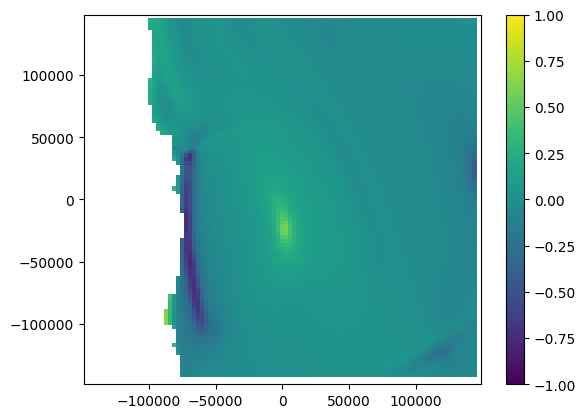

In [61]:
depth_lvl = 0
plt.pcolor(depth_dics2['Depth'+str(depth_lvl)]['X'], depth_dics2['Depth'+str(depth_lvl)]['Y'], depth_dics2['Depth'+str(depth_lvl)]['lnam'].T, vmin=-1,vmax=1)
plt.colorbar()
print(depth_dics2['Depth'+str(depth_lvl)]['ic'])
print(depth_dics2['Depth'+str(depth_lvl)]['jc'])
plt.scatter(depth_dics2['Depth'+str(depth_lvl)]['xc'], depth_dics2['Depth'+str(depth_lvl)]['yc'], marker='x', color='r')

Text(0.5, 0.98, 'TD = 16 km')

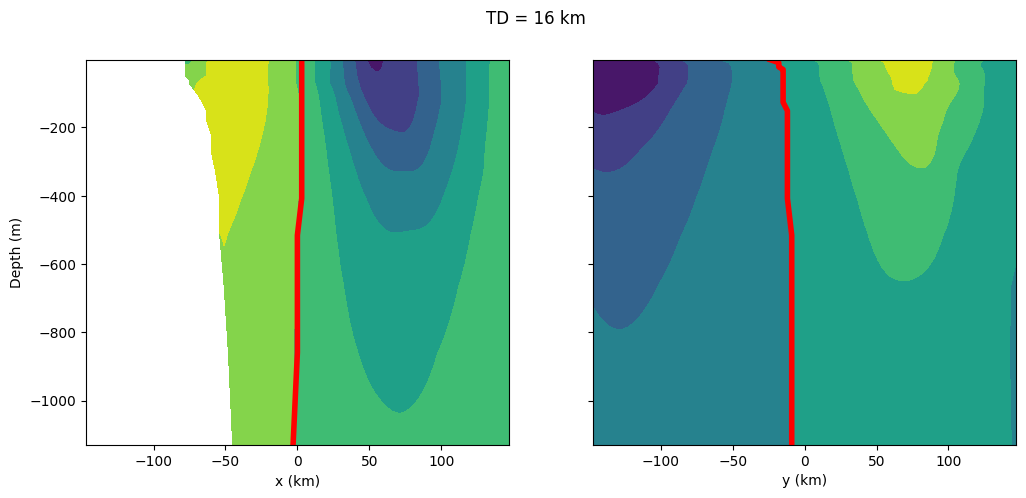

In [73]:
eddy = the_chosen_eddies[0]

t = 18

U = sample_data[eddy]['T'+str(t)]['U']
V = sample_data[eddy]['T'+str(t)]['V']
x = sample_data[eddy]['T'+str(t)]['x']/1000
y = sample_data[eddy]['T'+str(t)]['y']/1000
z = sample_data[eddy]['T'+str(t)]['z']
LNAM_data = sample_data[eddy]['T'+str(t)]['LNAM']

xc, yc, zc = LNAM_data.x, LNAM_data.y, LNAM_data.Depth

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
X, Z = np.meshgrid(x, z)
axs[0].contourf(X, Z, V[:, V.shape[1]//2, :].T)
axs[0].plot(xc, zc, linewidth=4, color='r')
axs[0].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (m)')
Y, Z = np.meshgrid(y, z)
axs[1].contourf(Y, Z, U[U.shape[0]//2, :, :].T)
axs[1].plot(yc, zc, linewidth=4, color='r')
axs[1].set_xlabel('y (km)')
# axs[1].set_ylabel('Depth (m)')
TD = f"{round(LNAM_data['TD'][0])} km" if 'TD' in LNAM_data and not np.isnan(VG_data['TD'][0]) else 'NaN'
plt.suptitle(f'TD = {TD}')

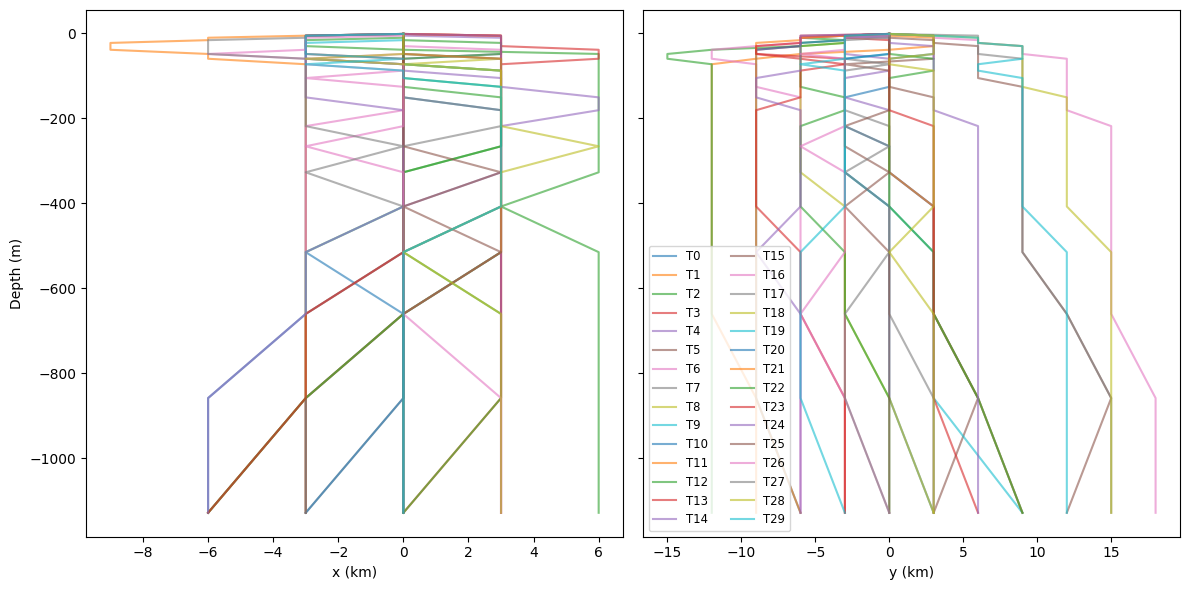

In [77]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

x_min, x_max = float('inf'), float('-inf')

for t in range(30):
    data = sample_data[eddy]['T' + str(t)]['LNAM']
    x_vals, y_vals = data['x'] - data['x'][0], data['y'] - data['y'][0]
    ax1.plot(x_vals, data['Depth'], alpha=0.6)
    ax2.plot(y_vals, data['Depth'], alpha=0.6, label='T' + str(t))
    x_min, x_max = min(x_min, x_vals.min(), y_vals.min()), max(x_max, x_vals.max(), y_vals.max())

# ax1.set_xlim(x_min, x_max)
# ax2.set_xlim(x_min, x_max)
ax1.set_xlabel("x (km)"); ax1.set_ylabel("Depth (m)")
ax2.set_xlabel("y (km)")
ax2.legend(loc='best', fontsize='small', ncol=2)
plt.tight_layout()
plt.show()

## MRes Plot

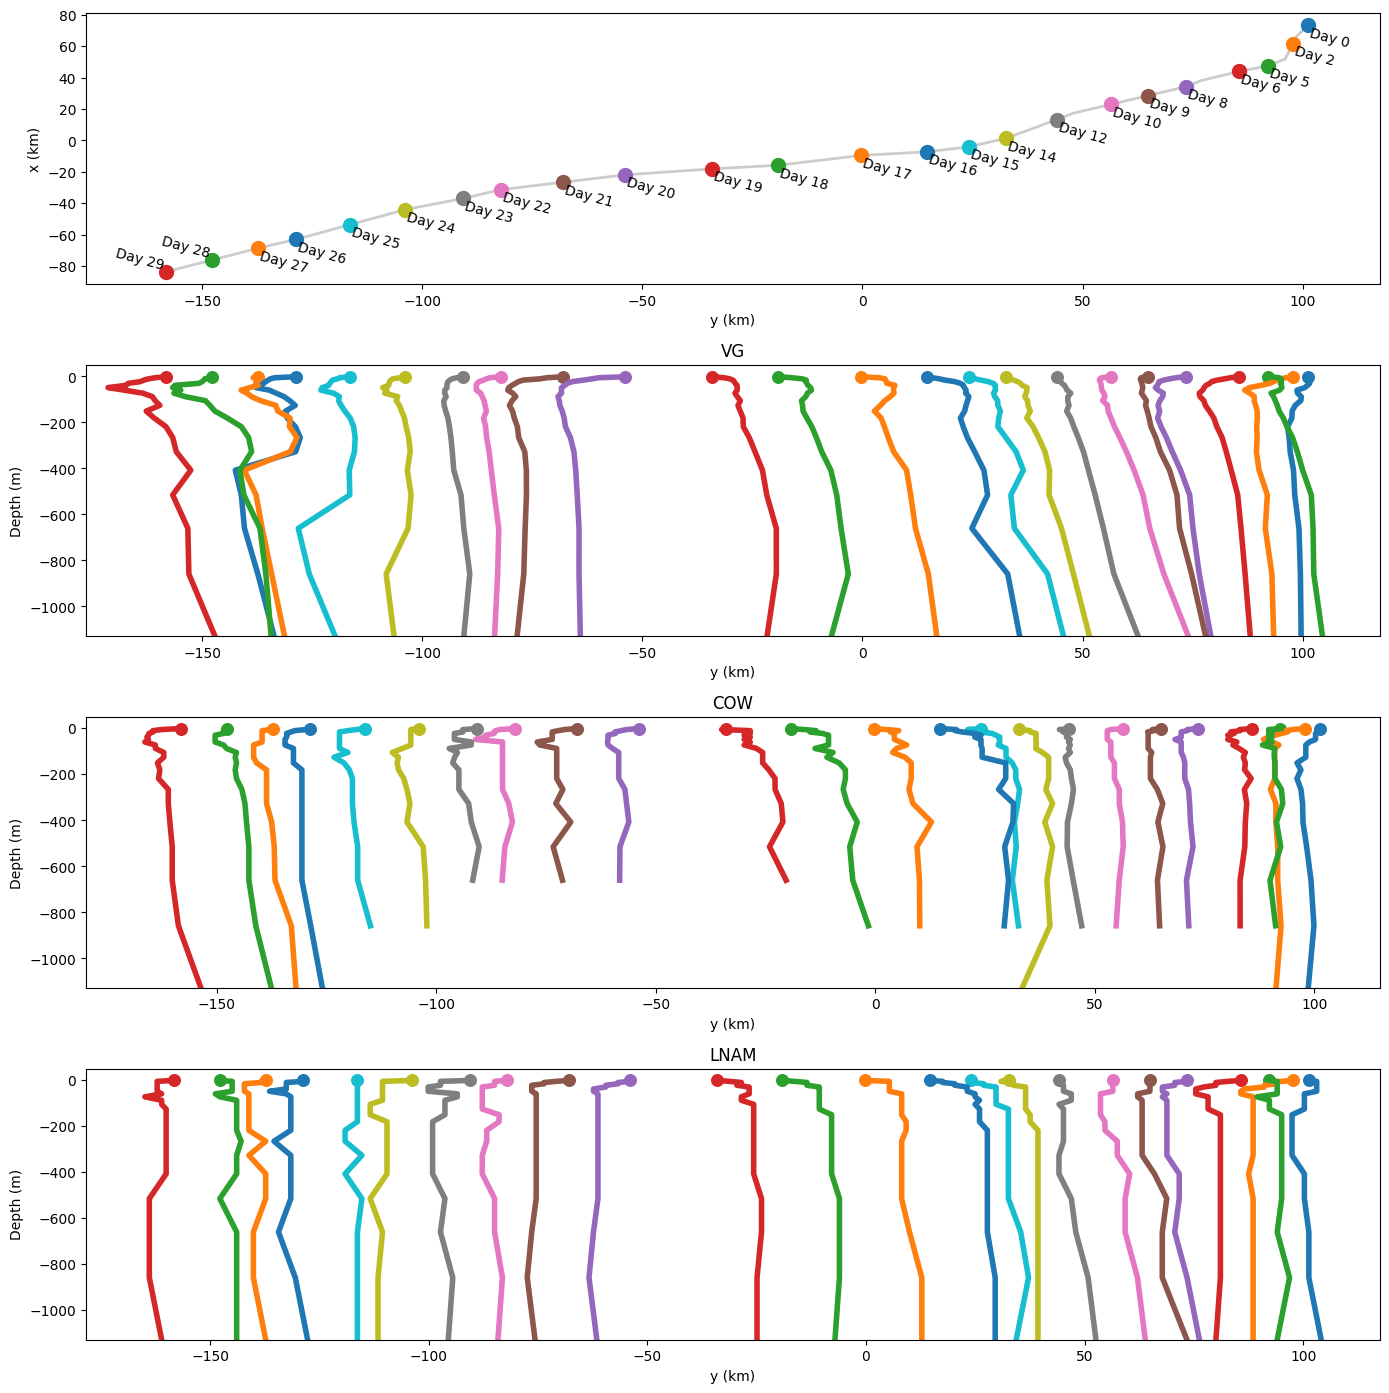

In [99]:
fig, axs = plt.subplots(4, 1, figsize=(14, 14))

# eddy = 'Eddy133' # AE tilt
eddy = 'Eddy134' # CE non-tilt
# eddy = 'Eddy22' # AE no-tilt
# eddy = 'Eddy149' # AE tilt
# eddy = 'Eddy134'

edata = eddies[eddy].iloc[eddies[eddy].shape[0] // 2 - 15:eddies[eddy].shape[0] // 2 + 15]
x, y = make_cartesian(edata.Lon, edata.Lat, edata.Lon.mean(), edata.Lat.mean())
eddy_path = pd.DataFrame({'x': x, 'y': y})

# Plot the eddy path
axs[0].plot(eddy_path['y'], eddy_path['x'], linewidth=2, color='k', alpha=.2)
axs[0].set_xlabel('y (km)')
axs[0].set_ylabel('x (km)')

y_min = float('inf')
y_max = float('-inf')
for t in range(30):
    time_data = sample_data[eddy]['T' + str(t)]['VG']
    x1, y1 = rotate_20_clockwise(time_data['x'], time_data['y'])
    y1 = y1 - y1[0] + eddy_path.iloc[t].y

    time_data = sample_data[eddy]['T' + str(t)]['COW']
    x2, y2 = rotate_20_clockwise(time_data['x'], time_data['y'])
    y2 = y2 - y2[0] + eddy_path.iloc[t].y

    time_data = sample_data[eddy]['T' + str(t)]['LNAM']
    x3, y3 = rotate_20_clockwise(time_data['x'], time_data['y'])
    y3 = y3 - y3[0] + eddy_path.iloc[t].y

    y_min = min(y_min, np.nanmin(y1), np.nanmin(y2), np.nanmin(y3), np.nanmin(eddy_path['y']))
    y_max = max(y_max, np.nanmax(y1), np.nanmax(y2), np.nanmax(y3), np.nanmax(eddy_path['y']))
y_min -= 5
y_max += 10

for t in list(set(range(30)) - {1, 3, 4, 7, 11, 13}):
    axs[0].scatter(eddy_path.iloc[t]['y'], eddy_path.iloc[t]['x'], s=100, zorder=5)
    if t in [28, 29]:
        axs[0].text(eddy_path.iloc[t]['y'], eddy_path.iloc[t]['x'], 'Day ' + str(t), ha='right', va='bottom', zorder=6, rotation=-15)
    else:
        axs[0].text(eddy_path.iloc[t]['y'], eddy_path.iloc[t]['x'], 'Day ' + str(t), ha='left', va='top', zorder=6, rotation=-15)
    
    time_data = sample_data[eddy]['T' + str(t)]['VG']
    x, y = rotate_20_clockwise(time_data['x'], time_data['y'])
    y = y - y[0] + eddy_path.iloc[t].y
    z = time_data['Depth']
    # INCLUDE THIS IN Y_MIN Y_MAX
    axs[1].plot(y, z, linewidth=4)
    axs[1].scatter(y[0], z[0], s=70)
    axs[1].set_ylim([50, z_r[150, 150, DEPTH_LVL_LIMIT-1]])
    axs[1].invert_yaxis()
    axs[1].set_title('VG')
    axs[1].set_xlabel('y (km)')
    axs[1].set_ylabel('Depth (m)')

    time_data = sample_data[eddy]['T' + str(t)]['COW']
    x, y = rotate_20_clockwise(time_data['x'], time_data['y'])
    y = y - y[0] + eddy_path.iloc[t].y
    z = time_data['Depth']
    # INCLUDE THIS IN Y_MIN Y_MAX
    axs[2].plot(y, z, linewidth=4)
    axs[2].scatter(y[0], z[0], s=70)
    axs[2].set_ylim([50, z_r[150, 150, DEPTH_LVL_LIMIT-1]])
    axs[2].invert_yaxis()
    axs[2].set_title('COW')
    axs[2].set_xlabel('y (km)')
    axs[2].set_ylabel('Depth (m)')

    time_data = sample_data[eddy]['T' + str(t)]['LNAM']
    x, y = rotate_20_clockwise(time_data['x'], time_data['y'])
    y = y - y[0] + eddy_path.iloc[t].y
    z = time_data['Depth']
    # INCLUDE THIS IN Y_MIN Y_MAX
    axs[3].plot(y, z, linewidth=4)
    axs[3].scatter(y[0], z[0], s=70)
    axs[3].set_ylim([50, z_r[150, 150, DEPTH_LVL_LIMIT-1]])
    axs[3].invert_yaxis()
    axs[3].set_title('LNAM')
    axs[3].set_xlabel('y (km)')
    axs[3].set_ylabel('Depth (m)')

axs[0].set_xlim(y_min, y_max)
axs[1].set_xlim(y_min, y_max)

# plt.suptitle(eddy)
plt.tight_layout()
plt.show()


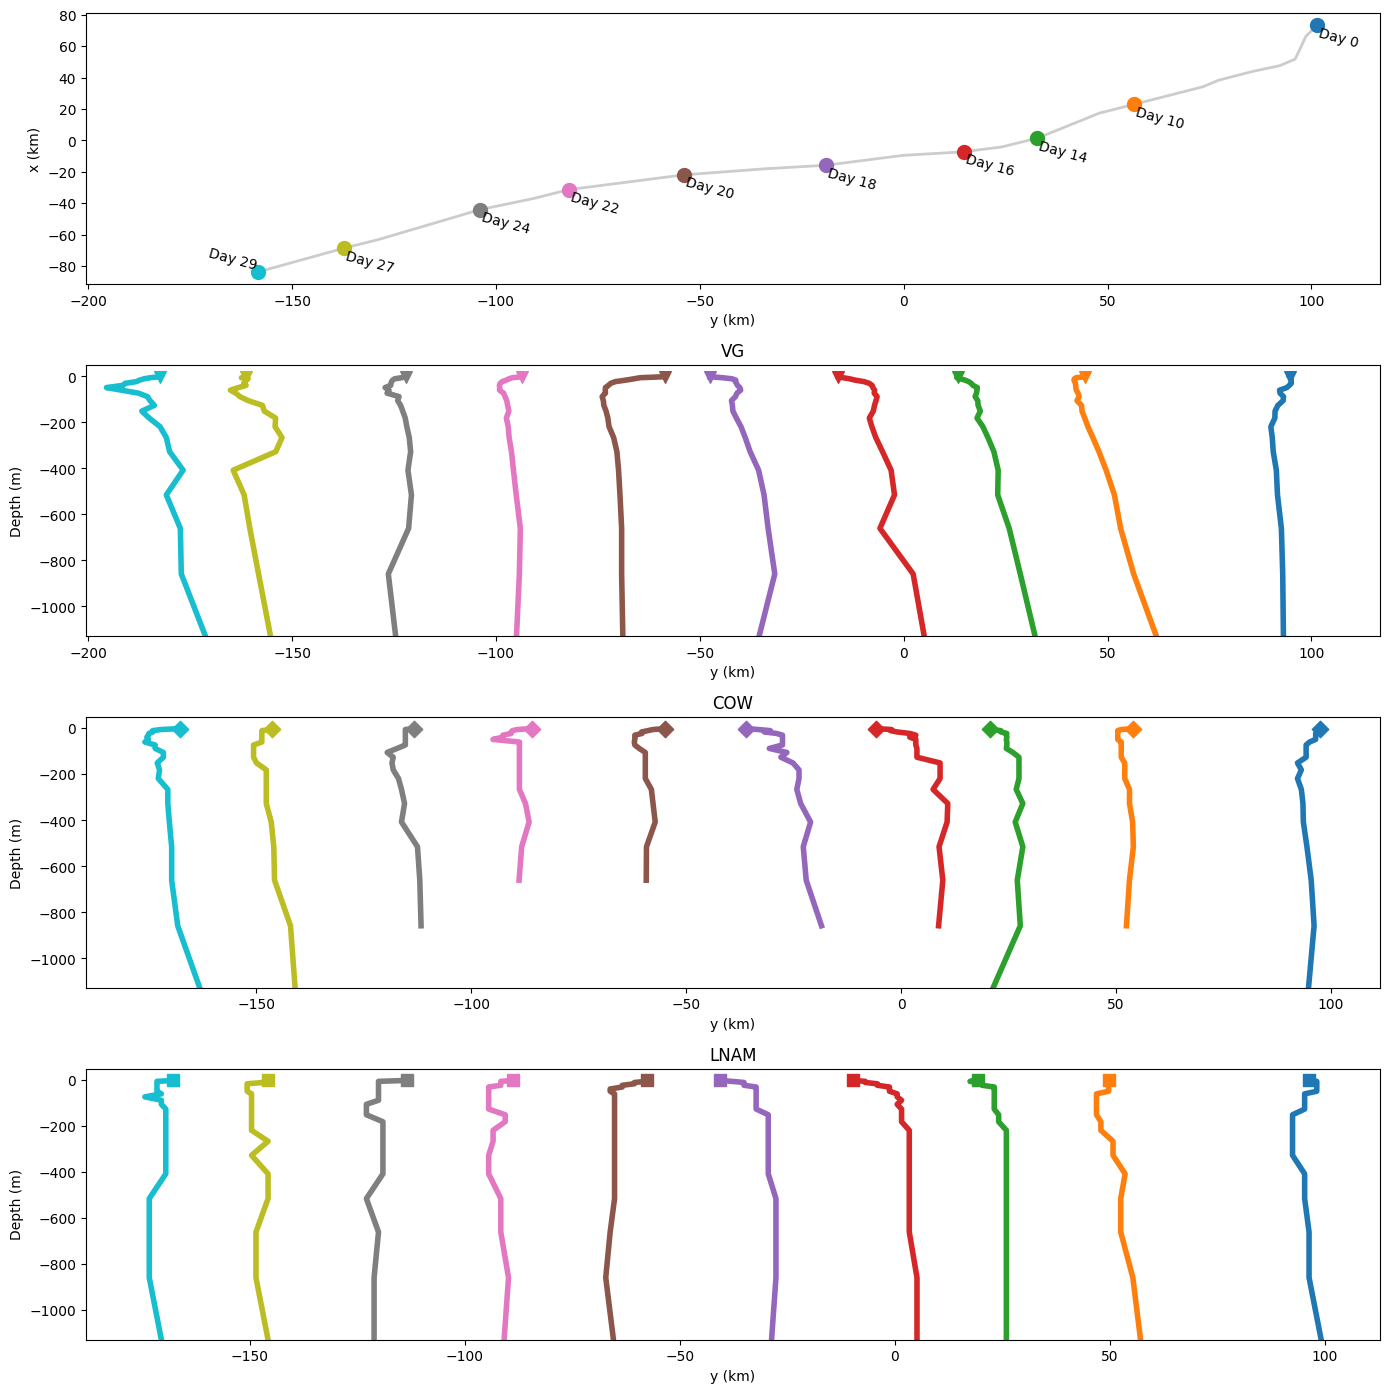

In [122]:
fig, axs = plt.subplots(4, 1, figsize=(14, 14))

# eddy = 'Eddy133' # AE tilt
eddy = 'Eddy134' # CE non-tilt
# eddy = 'Eddy22' # AE no-tilt
# eddy = 'Eddy149' # AE tilt
# eddy = 'Eddy134'

edata = eddies[eddy].iloc[eddies[eddy].shape[0] // 2 - 15:eddies[eddy].shape[0] // 2 + 15]
x, y = make_cartesian(edata.Lon, edata.Lat, edata.Lon.mean(), edata.Lat.mean())
eddy_path = pd.DataFrame({'x': x, 'y': y})

# Plot the eddy path
axs[0].plot(eddy_path['y'], eddy_path['x'], linewidth=2, color='k', alpha=.2)
axs[0].set_xlabel('y (km)')
axs[0].set_ylabel('x (km)')

y_min = float('inf')
y_max = float('-inf')
for t in range(30):
    time_data = sample_data[eddy]['T' + str(t)]['VG']
    x1, y1 = rotate_20_clockwise(time_data['x'], time_data['y'])
    y1 = y1 + eddy_path.iloc[t].y

    time_data = sample_data[eddy]['T' + str(t)]['COW']
    x2, y2 = rotate_20_clockwise(time_data['x'], time_data['y'])
    y2 = y2 + eddy_path.iloc[t].y

    time_data = sample_data[eddy]['T' + str(t)]['LNAM']
    x3, y3 = rotate_20_clockwise(time_data['x'], time_data['y'])
    y3 = y3 + eddy_path.iloc[t].y

    y_min = min(y_min, np.nanmin(y1), np.nanmin(y2), np.nanmin(y3), np.nanmin(eddy_path['y']))
    y_max = max(y_max, np.nanmax(y1), np.nanmax(y2), np.nanmax(y3), np.nanmax(eddy_path['y']))
y_min -= 5
y_max += 10

for t in [0,10,14,16,18,20,22,24,27, 29]:
    axs[0].scatter(eddy_path.iloc[t]['y'], eddy_path.iloc[t]['x'], s=100, zorder=5)

    # time_data = sample_data[eddy]['T' + str(t)]['VG']
    # x, y = rotate_20_clockwise(time_data['x'], time_data['y'])
    # x, y = x[0] + eddy_path.iloc[t]['x'], y[0] + eddy_path.iloc[t]['y']
    # axs[0].scatter(y, x, s=100, zorder=5, marker='$V$')
    # time_data = sample_data[eddy]['T' + str(t)]['COW']
    # x, y = rotate_20_clockwise(time_data['x'], time_data['y'])
    # x, y = x[0] + eddy_path.iloc[t]['x'], y[0] + eddy_path.iloc[t]['y']
    # axs[0].scatter(y, x, s=100, zorder=5, marker='$C$')
    # time_data = sample_data[eddy]['T' + str(t)]['LNAM']
    # x, y = rotate_20_clockwise(time_data['x'], time_data['y'])
    # x, y = x[0] + eddy_path.iloc[t]['x'], y[0] + eddy_path.iloc[t]['y']
    # axs[0].scatter(y, x, s=100, zorder=5, marker='$L$')

    if t in [28, 29]:
        axs[0].text(eddy_path.iloc[t]['y'], eddy_path.iloc[t]['x'], 'Day ' + str(t), ha='right', va='bottom', zorder=6, rotation=-15)
    else:
        axs[0].text(eddy_path.iloc[t]['y'], eddy_path.iloc[t]['x'], 'Day ' + str(t), ha='left', va='top', zorder=6, rotation=-15)
    
    time_data = sample_data[eddy]['T' + str(t)]['VG']
    x, y = rotate_20_clockwise(time_data['x'], time_data['y'])
    y = y + eddy_path.iloc[t].y
    z = time_data['Depth']
    axs[1].plot(y, z, linewidth=4)
    axs[1].scatter(y[0], z[0], s=70, marker='v')
    axs[1].set_ylim([50, z_r[150, 150, DEPTH_LVL_LIMIT-1]])
    axs[1].invert_yaxis()
    axs[1].set_title('VG')
    axs[1].set_xlabel('y (km)')
    axs[1].set_ylabel('Depth (m)')

    time_data = sample_data[eddy]['T' + str(t)]['COW']
    x, y = rotate_20_clockwise(time_data['x'], time_data['y'])
    y = y + eddy_path.iloc[t].y
    z = time_data['Depth']
    axs[2].plot(y, z, linewidth=4)
    axs[2].scatter(y[0], z[0], s=70, marker='D')
    axs[2].set_ylim([50, z_r[150, 150, DEPTH_LVL_LIMIT-1]])
    axs[2].invert_yaxis()
    axs[2].set_title('COW')
    axs[2].set_xlabel('y (km)')
    axs[2].set_ylabel('Depth (m)')

    time_data = sample_data[eddy]['T' + str(t)]['LNAM']
    x, y = rotate_20_clockwise(time_data['x'], time_data['y'])
    y = y + eddy_path.iloc[t].y
    z = time_data['Depth']
    axs[3].plot(y, z, linewidth=4)
    axs[3].scatter(y[0], z[0], s=70, marker='s')
    axs[3].set_ylim([50, z_r[150, 150, DEPTH_LVL_LIMIT-1]])
    axs[3].invert_yaxis()
    axs[3].set_title('LNAM')
    axs[3].set_xlabel('y (km)')
    axs[3].set_ylabel('Depth (m)')

axs[0].set_xlim(y_min, y_max)
axs[1].set_xlim(y_min, y_max)

# plt.suptitle(eddy)
plt.tight_layout()
plt.show()